In [1]:
#Check if we run on GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug 16 14:50:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
####Mount GG drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls

gdrive	sample_data


## Load in data

In [6]:
!pip install patool
import os
os.makedirs("food_130_full")
import patoolib
patoolib.extract_archive("/content/gdrive/MyDrive/full_data.rar", outdir="food_130_full")

     |████████████████████████████████| 77 kB 4.3 MB/s 
patool: Extracting /content/gdrive/MyDrive/full_data.rar ...
patool: running /usr/bin/unrar x -- /content/gdrive/MyDrive/full_data.rar
patool:     with cwd='food_130_full'
patool: ... /content/gdrive/MyDrive/full_data.rar extracted to `food_130_full'.


'food_130_full'

In [7]:

### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
# 224 x 224 since we are using EffiencientNetB0
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
train_dir = "food_130_full/full_data/train/"
test_dir = "food_130_full/full_data/test/"

# How many images/classes are there?
walk_through_dir("food_130_full/full_data")

In [27]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
# train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
#                                                                                 label_mode="categorical",
#                                                                                 image_size=IMG_SIZE)
                                                                                
# test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
#                                                                 label_mode="categorical",
#                                                                 image_size=IMG_SIZE,
#                                                                 shuffle=False) # don't shuffle test data for prediction analysis
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")                                                                

Training images:
Found 94265 images belonging to 130 classes.
Testing images:
Found 31064 images belonging to 130 classes.


In [20]:
train_data.num_classes

130

## Train model

In [28]:
# Create checkpoint callback to save model for later use
checkpoint_path = "food_130_full_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [16]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
train_data_10_percent

In [29]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(train_data.num_classes, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [ ]:
len(train_data_all.class_names)

130

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 130)               166530    
Total params: 4,216,101
Trainable params: 166,530
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes = model.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
 676/2946 [=====>........................] - ETA: 9:22 - loss: 3.0011 - accuracy: 0.3388

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 837s 282ms/step - loss: 2.2608 - accuracy: 0.4655 - val_loss: 1.4564 - val_accuracy: 0.6203
Epoch 2/5
2946/2946 [==============================] - 788s 268ms/step - loss: 1.7386 - accuracy: 0.5640 - val_loss: 1.3550 - val_accuracy: 0.6371
Epoch 3/5
2946/2946 [==============================] - 795s 270ms/step - loss: 1.6082 - accuracy: 0.5935 - val_loss: 1.3194 - val_accuracy: 0.6502
Epoch 4/5
2946/2946 [==============================] - 796s 270ms/step - loss: 1.5291 - accuracy: 0.6082 - val_loss: 1.2970 - val_accuracy: 0.6522
Epoch 5/5
2946/2946 [==============================] - 791s 268ms/step - loss: 1.4773 - accuracy: 0.6198 - val_loss: 1.2530 - val_accuracy: 0.6621


In [31]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

971/971 [==============================] - 235s 242ms/step - loss: 1.2812 - accuracy: 0.6587


[1.2812076807022095, 0.6587046384811401]

Not too bad for the first attempt

## Save the base model

In [33]:
## Saving model to Google Drive 

# Create save path to drive 
save_dir = "gdrive/MyDrive/food_130_app/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: gdrive/MyDrive/food_130_app/assets


## Fine tune


When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [34]:
# Are any of the layers in our model frozen?
for layer in model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
global_average_pooling True float32 <Policy "float32">
output_layer True float32 <Policy "float32">


In [38]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[2].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_1 True float32 <Policy "float32">
normalization_1 True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">
block1a_se_squeeze True float32 <Policy "float32">
block1a_se_reshape True float32 <Policy "float32">
block1a_se_reduce True float32 <Policy "float32">
block1a_se_expand True float32 <Policy "float32">
block1a_se_excite True float32 <Policy "float32">
block1a_project_conv True float32 <Policy "float32">
block1a_project_bn True float32 <Policy "float32">
block2a_expand_conv True float32 <Policy "float32">
block2a_expand_bn True float32 <Policy "float32">
block2a_expand_activation True float32 <Policy "float32">


## Create a few more callbacks

In [39]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [40]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [41]:
# Compile the model
model.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

## Fine-tune training

In [42]:
# Start to fine-tune (all layers)
history_food_130_fine_tune = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_food_130_fine_tuning"), # track the model training logs
                                                  model_checkpoint, # save only the best model during training
                                                  early_stopping, # stop model after X epochs of no improvements
                                                  reduce_lr],  # reduce the learning rate after X epochs of no improvements
                                       verbose=1)

Saving TensorBoard log files to: training_logs/efficientb0_food_130_fine_tuning/20210816-170100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
2055/2946 [===================>..........] - ETA: 5:07 - loss: 1.2033 - accuracy: 0.6839

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 1045s 352ms/step - loss: 1.1591 - accuracy: 0.6934 - val_loss: 1.1912 - val_accuracy: 0.6765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 2/100
 164/2946 [>.............................] - ETA: 14:43 - loss: 0.9164 - accuracy: 0.7487

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 996s 338ms/step - loss: 0.9066 - accuracy: 0.7547 - val_loss: 1.0951 - val_accuracy: 0.6931


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 3/100
 480/2946 [===>..........................] - ETA: 12:59 - loss: 0.7417 - accuracy: 0.7948

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 990s 336ms/step - loss: 0.7624 - accuracy: 0.7892 - val_loss: 1.0237 - val_accuracy: 0.7213


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 4/100
2270/2946 [======================>.......] - ETA: 3:37 - loss: 0.6398 - accuracy: 0.8179

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 992s 337ms/step - loss: 0.6474 - accuracy: 0.8163 - val_loss: 0.9590 - val_accuracy: 0.7446


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 5/100
 262/2946 [=>............................] - ETA: 14:27 - loss: 0.5041 - accuracy: 0.8526

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 993s 337ms/step - loss: 0.5540 - accuracy: 0.8406 - val_loss: 0.9724 - val_accuracy: 0.7371
Epoch 6/100
2946/2946 [==============================] - 988s 335ms/step - loss: 0.4744 - accuracy: 0.8610 - val_loss: 1.0239 - val_accuracy: 0.7437

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 7/100
2946/2946 [==============================] - 984s 334ms/step - loss: 0.2761 - accuracy: 0.9191 - val_loss: 1.0208 - val_accuracy: 0.7627


In [43]:
model.evaluate(test_data)

971/971 [==============================] - 238s 245ms/step - loss: 1.0209 - accuracy: 0.7587


[1.020851492881775, 0.7587239146232605]

In [44]:
## Saving the 2nd model to Google Drive 

# Create save path to drive 
save_dir = "gdrive/MyDrive/food_130_app_tuned_v1/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: gdrive/MyDrive/food_130_app_tuned_v1/assets


## Loss curves

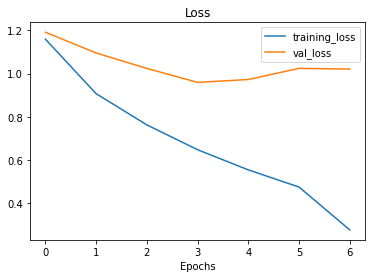

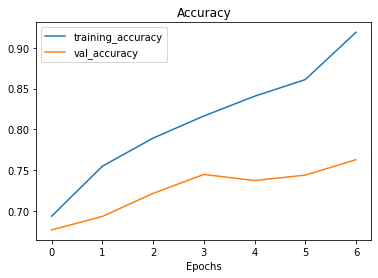

In [45]:
plot_loss_curves(history_food_130_fine_tune)

In [46]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

--2021-08-16 19:14:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  27.6MB/s    in 0.5s    

2021-08-16 19:14:34 (27.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

In [49]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['apple_pie' 'baby_back_ribs' 'baklava' 'banh_beo' 'banh_bot_loc'
 'banh_can' 'banh_canh' 'banh_chung' 'banh_cuon' 'banh_duc' 'banh_gio'
 'banh_khot' 'banh_mi' 'banh_pia' 'banh_tet' 'banh_trang_nuong' 'banh_xeo'
 'beef_carpaccio' 'beef_tartare' 'beet_salad' 'beignets' 'bibimbap'
 'bread_pudding' 'breakfast_burrito' 'bruschetta' 'bun_bo_hue'
 'bun_dau_mam_tom' 'bun_mam' 'bun_rieu' 'bun_thit_nuong' 'ca_kho_to'
 'caesar_salad' 'canh_chua' 'cannoli' 'cao_lau' 'caprese_salad'
 'carrot_cake' 'ceviche' 'chao_long' 'cheese_plate' 'cheesecake'
 'chicken_curry' 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake'
 'chocolate_mousse' 'churros' 'clam_chowder' 'club_sandwich' 'com_tam'
 'crab_cakes' 'creme_brulee' 'croque_madame' 'cup_cakes' 'deviled_eggs'
 'donuts' 'dumplings' 'edamame' 'eggs_benedict' 'escargots' 'falafel'
 'filet_mignon' 'fish_and_chips' 'foie_gras' 'french_fries'
 'french_onion_soup' 'french_toast' 'fried_calamari' 'fried_rice'
 'frozen_yogurt' 'garlic_bread' 'gnocchi' 'goi_cu

In [50]:
len(class_names)

130

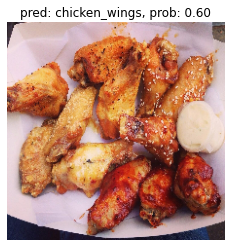

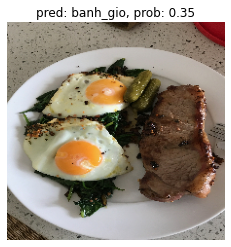

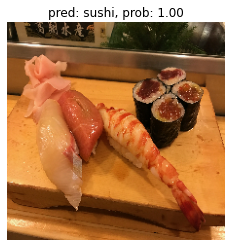

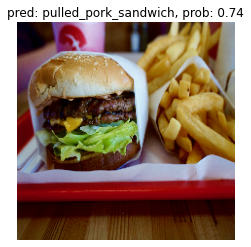

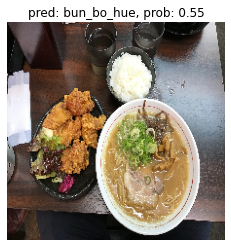

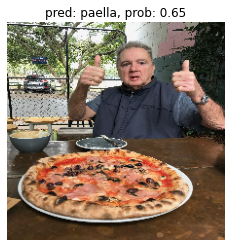

In [51]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

## More epochs

In [54]:
# Compile the model
model.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [55]:
# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints_v2/"
model_checkpoint_v2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 130)               166530    
Total params: 4,216,101
Trainable params: 4,174,078
Non-trainable params: 42,023
_________________________________________________________________


In [58]:
# Start to fine-tune (all layers)
history_food_130_fine_tune_v2 = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      initial_epoch = history_food_130_fine_tune.epoch[-1],
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_food_130_fine_tuning_v2"), # track the model training logs
                                                  model_checkpoint_v2, # save only the best model during training
                                                  early_stopping, # stop model after X epochs of no improvements
                                                  reduce_lr],  # reduce the learning rate after X epochs of no improvements
                                       verbose=1)

Saving TensorBoard log files to: training_logs/efficientb0_food_130_fine_tuning_v2/20210816-192659


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
1276/2946 [===========>..................] - ETA: 9:19 - loss: 0.3602 - accuracy: 0.8910

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 1051s 354ms/step - loss: 0.3845 - accuracy: 0.8843 - val_loss: 1.0661 - val_accuracy: 0.7287


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints_v2/assets
Epoch 8/100
 395/2946 [===>..........................] - ETA: 13:25 - loss: 0.2970 - accuracy: 0.9087

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 987s 335ms/step - loss: 0.3350 - accuracy: 0.8972 - val_loss: 1.0986 - val_accuracy: 0.7345
Epoch 9/100
2946/2946 [==============================] - 990s 336ms/step - loss: 0.2895 - accuracy: 0.9103 - val_loss: 1.2720 - val_accuracy: 0.7127

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 10/100
2946/2946 [==============================] - 992s 337ms/step - loss: 0.1439 - accuracy: 0.9556 - val_loss: 1.1860 - val_accuracy: 0.7545


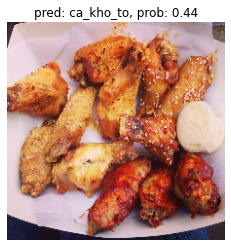

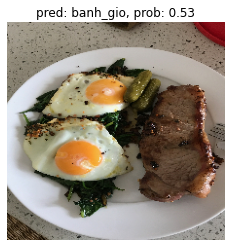

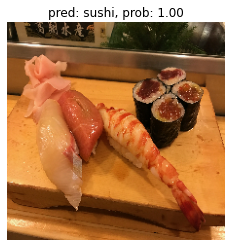

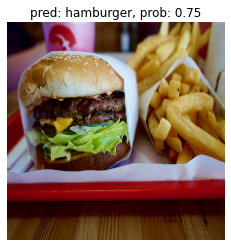

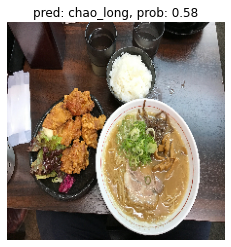

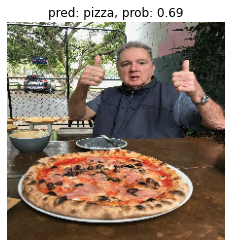

In [71]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [60]:
# Start to fine-tune (all layers)
history_food_130_fine_tune_v3 = model.fit(train_data,
                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                      initial_epoch = history_food_130_fine_tune_v2.epoch[-1],
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_food_130_fine_tuning_v3"), # track the model training logs
                                                  model_checkpoint_v2, # save only the best model during training
                                                  early_stopping, # stop model after X epochs of no improvements
                                                  reduce_lr],  # reduce the learning rate after X epochs of no improvements
                                       verbose=1)

Saving TensorBoard log files to: training_logs/efficientb0_food_130_fine_tuning_v3/20210816-204535


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
2540/2946 [========================>.....] - ETA: 2:12 - loss: 0.1134 - accuracy: 0.9653

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2946/2946 [==============================] - 999s 339ms/step - loss: 0.1143 - accuracy: 0.9647 - val_loss: 1.2430 - val_accuracy: 0.7504
Epoch 11/100
2946/2946 [==============================] - 1028s 349ms/step - loss: 0.0979 - accuracy: 0.9694 - val_loss: 1.2849 - val_accuracy: 0.7519
Epoch 12/100
2946/2946 [==============================] - 991s 336ms/step - loss: 0.0875 - accuracy: 0.9731 - val_loss: 1.3625 - val_accuracy: 0.7498

Epoch 00012: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 13/100
2946/2946 [==============================] - 989s 336ms/step - loss: 0.0653 - accuracy: 0.9801 - val_loss: 1.3749 - val_accuracy: 0.7463


(-0.5, 223.5, 223.5, -0.5)

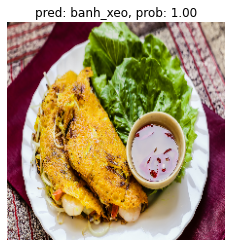

In [66]:
# Make predictions on custom food images

img = load_and_prep_image("banh_xeo.jpg", scale=False) # load in target image and turn it into tensor
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class label
# Plot the image with appropriate annotations
plt.figure()
plt.imshow(img/255.); # imshow() requires float inputs to be normalized
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)

In [67]:
## Saving the 3nd model to Google Drive 

# Create save path to drive 
save_dir = "gdrive/MyDrive/food_130_app_tuned_v2/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: gdrive/MyDrive/food_130_app_tuned_v2/assets


## Load the saved model

In [68]:
loaded_model = tf.keras.models.load_model("/content/fine_tune_checkpoints_v2")
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 130)               166530    
Total params: 4,216,101
Trainable params: 4,174,078
Non-trainable params: 42,023
_________________________________________________________________


In [69]:
loaded_model.evaluate(test_data)

971/971 [==============================] - 240s 246ms/step - loss: 1.0885 - accuracy: 0.7301


[1.088513970375061, 0.7301377654075623]

(-0.5, 223.5, 223.5, -0.5)

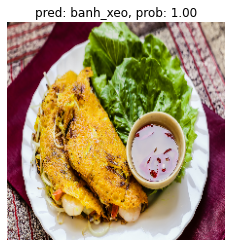

In [70]:
# Make predictions on custom food images

img = load_and_prep_image("banh_xeo.jpg", scale=False) # load in target image and turn it into tensor
pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class label
# Plot the image with appropriate annotations
plt.figure()
plt.imshow(img/255.); # imshow() requires float inputs to be normalized
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)

In [73]:
list(class_names)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'banh_beo',
 'banh_bot_loc',
 'banh_can',
 'banh_canh',
 'banh_chung',
 'banh_cuon',
 'banh_duc',
 'banh_gio',
 'banh_khot',
 'banh_mi',
 'banh_pia',
 'banh_tet',
 'banh_trang_nuong',
 'banh_xeo',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'bun_bo_hue',
 'bun_dau_mam_tom',
 'bun_mam',
 'bun_rieu',
 'bun_thit_nuong',
 'ca_kho_to',
 'caesar_salad',
 'canh_chua',
 'cannoli',
 'cao_lau',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'chao_long',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'com_tam',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries'